## G2M insight for Cab Investment firm
Data Glacier - Henri Edwards

The Client XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

Datasets contain information on 2 cab companies. Each file (data set) provided represents different aspects of the customer profile. XYZ is interested in using your actionable insights to help them identify the right company to make their investment.

<a id="cont"></a>

### Table of Contents

<a href=#1>1. Importing Packages</a>

<a href=#2>2. Loading the Data</a>

<a href=#3>3. Data Cleaning & Preprocessing</a>

<a href=#4>4. Model Building</a>

<a href=#5>5. Conclusion</a>

### 1. Importing Packages
<a class="anchor" id="1"></a>
<a href=#cont>Back to Table of Contents</a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np 
from numpy import std
from numpy import mean
from scipy import stats
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
sns.set_theme(style="whitegrid")

import sklearn
from math import sqrt
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

from xgboost.sklearn import XGBRegressor
import xgboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

### 2. Loading the Data
<a class="anchor" id="2"></a>
<a href=#cont>Back to Table of Contents</a>

- **Cab_Data.csv** – this file includes details of transaction for 2 cab companies
- **Customer_ID.csv** – this is a mapping table that contains a unique identifier which links the customer’s demographic details
- **Transaction_ID.csv** – this is a mapping table that contains transaction to customer mapping and payment mode
- **City.csv – this file** contains list of US cities, their population and number of cab users

In [2]:
cab_data = pd.read_csv('Cab_Data.csv')
city_data = pd.read_csv('City.csv')
customer_id = pd.read_csv('Customer_ID.csv')
transaction_id = pd.read_csv('Transaction_ID.csv')

In [3]:
cab_data.head(3)

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,08-01-2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,06-01-2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,02-01-2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632


In [4]:
city_data.head(3)

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"


In [5]:
customer_id.head(3)

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242


In [6]:
transaction_id.head(3)

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash


### 3. Data Cleaning & Preprocessing
<a class="anchor" id="3"></a>
<a href=#cont>Back to Table of Contents</a>

- Merge/Create necessary dataframes

- Inspect Null values

- Inspect Data Types

- Feature Engineering

In [7]:
# combine dataframes
combined_df = cab_data.merge(transaction_id,on='Transaction ID').merge(customer_id,on='Customer ID').merge(city_data,on='City')

In [8]:
combined_df.head(5)

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,08-01-2016,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,"814,885","24,701"
1,10351127,21-07-2018,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,"814,885","24,701"
2,10412921,23-11-2018,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,"814,885","24,701"
3,10000012,06-01-2016,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,"814,885","24,701"
4,10320494,21-04-2018,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,"814,885","24,701"


In [9]:
# view total null values per feature
combined_df.isnull().sum()

Transaction ID        0
Date of Travel        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Customer ID           0
Payment_Mode          0
Gender                0
Age                   0
Income (USD/Month)    0
Population            0
Users                 0
dtype: int64

In [10]:
combined_df.dtypes

Transaction ID          int64
Date of Travel         object
Company                object
City                   object
KM Travelled          float64
Price Charged         float64
Cost of Trip          float64
Customer ID             int64
Payment_Mode           object
Gender                 object
Age                     int64
Income (USD/Month)      int64
Population             object
Users                  object
dtype: object

In [11]:
# Date of Travel is currently viewed as an object by Pandas, we need to convert it to a datetime object.
combined_df['Date of Travel'] = pd.to_datetime(combined_df['Date of Travel'], format='%d-%m-%Y')

In [12]:
# Convert relevant features from object to numerical data types
combined_df['Population'] = combined_df['Population'].replace(',','', regex=True)
combined_df['Population'] = combined_df['Population'].astype('int64')
combined_df['Users'] = combined_df['Users'].replace(',','', regex=True)
combined_df['Users'] = combined_df['Users'].astype('int64')

In [13]:
# Replace spaces with '_' in features
for col in combined_df.columns:
    if ' ' in col:
        combined_df = combined_df.rename(columns={col:col.replace(' ','_')})

In [14]:
# Change Income_(USD/Month) to more useful name
combined_df.rename(columns = {'Income_(USD/Month)':'income_usd_pm'}, inplace = True)

In [17]:
# Extract/Create Month & year feature
month=[]
year=[]
day=[]
for i in range(len(combined_df['Date_of_Travel'])):
    day.append(combined_df['Date_of_Travel'][i].day)
    month.append(combined_df['Date_of_Travel'][i].month)
    year.append(combined_df['Date_of_Travel'][i].year)
combined_df['Month'] = month
combined_df['day'] = day
combined_df['Year'] = year

In [18]:
combined_df['payment_mode'] = combined_df.Payment_Mode.map(dict(Card=1, Cash=0))
combined_df.drop(['Date_of_Travel', 'City', 'Gender', 'Payment_Mode'], axis=1, inplace=True)

In [19]:
# Create dataframe for only yellow company.
yellow_cab = combined_df[combined_df['Company'] == 'Yellow Cab']

In [21]:
yellow_cab.head(3)

,Transaction_ID,Company,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Age,income_usd_pm,Population,Users,Month,day,Year,payment_mode
1,10351127,Yellow Cab,26.19,598.70,317.4228,29290,28,10813,814885,24701,7,21,2018,0
2,10412921,Yellow Cab,42.55,792.05,597.4020,29290,28,10813,814885,24701,11,23,2018,1
4,10320494,Yellow Cab,36.38,721.10,467.1192,27703,27,9237,814885,24701,4,21,2018,1


#### Data Cleaning Conclusions
- No null values present in the data
- Combined dataframes
- Coverted necessary datatypes
- Features Engineered

### 4. Model Building
Building and Evaluating Models able to predict Price_Charged for the Yellow Cab company.

<a class="anchor" id="4"></a>
<a href=#cont>Back to Table of Contents</a>

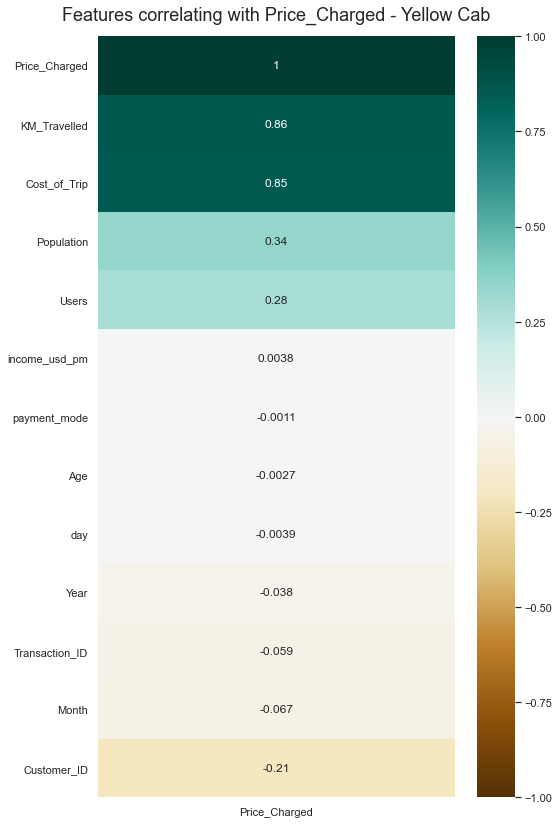

In [22]:
# Correlation Heatmap - Features correlated to Price_Charged
plt.figure(figsize=(8,14))
hm = sns.heatmap(yellow_cab.corr()[['Price_Charged']].sort_values(by='Price_Charged', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
hm.set_title('Features correlating with Price_Charged - Yellow Cab', fontdict={'fontsize':18}, pad=16);

- Strong Positive Correlation: Km_Travelled & Cost_of_Trip.
- Medium Positive Correlation: Population & Users.
- Medium Negative Correlation: Customer_ID.

In [23]:
yellow_cab.drop(['Company'], axis=1, inplace=True)

<ipython-input-23-0c582a8fc2cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yellow_cab.drop(['Company'], axis=1, inplace=True)


In [24]:
# Create targets and features dataframes then seperate the test from the train data set.
yellow_y = yellow_cab['Price_Charged']
yellow_x = yellow_cab.drop(['Price_Charged'], axis=1)

In [25]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(yellow_x, yellow_y, test_size=0.1, random_state=42)

### Feature Scaling
Apply Normilization to X features.

In [26]:
# Scaling of data

scale = MinMaxScaler() 

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
X_std = pd.DataFrame(X_train, columns=yellow_x.columns)
X_std.head()



,Transaction_ID,KM_Travelled,Cost_of_Trip,Customer_ID,Age,income_usd_pm,Population,Users,Month,day,Year,payment_mode
0,0.110076,0.746204,0.747935,0.802747,0.425532,0.098406,0.035935,0.000000,0.454545,0.833333,0.0,1.0
1,0.920377,1.000000,0.913824,0.088568,0.085106,0.902321,0.209169,0.538766,0.909091,0.300000,1.0,0.0
2,0.245378,0.547505,0.550592,0.001033,0.468085,0.207298,1.000000,1.000000,0.909091,0.533333,0.0,1.0
3,0.265989,0.370933,0.354758,0.493658,0.085106,0.002425,0.069379,0.070545,1.000000,0.333333,0.0,1.0
4,0.480413,0.547072,0.535555,0.231837,0.276596,0.057037,0.113848,0.079074,0.636364,0.566667,0.5,1.0


### Model Training

In [27]:
# train Ridge()
ridge = Ridge()
ridge.fit(X_train, y_train)

# train DecisionTreeRegressor()
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

# train LinearRegression()
lm = LinearRegression()
lm.fit(X_train, y_train)

# train KNeighborsRegressor()
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)

# train XGBRegressor()
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### Model performance

In [28]:
ridge_predict = ridge.predict(X_test)
ridge_RMSE = sqrt(metrics.mean_squared_error(y_test, ridge_predict))

dtr_predict = dtr.predict(X_test)
dtr_RMSE = sqrt(metrics.mean_squared_error(y_test, dtr_predict))

lm_predict = lm.predict(X_test)
lm_RMSE = metrics.mean_squared_error(y_test, lm_predict, squared=False)

knn_predict = knn.predict(X_test)
knn_RMSE = metrics.mean_squared_error(y_test, knn_predict, squared=False)

xgb_predict = xgb.predict(X_test)
XGB_RMSE = metrics.mean_squared_error(y_test, xgb_predict, squared=False)

In [29]:
# Comparing model performance. New dataframe containing test RMSE values 
RMSE_dict = {'Test_RMSE':
             {
                 "Ridge Regression": ridge_RMSE,
                "Decision Tree Regression": dtr_RMSE,
              "Linear Regression": lm_RMSE,
              "KNeighbors Regression": knn_RMSE,
                 "XGB Regression": XGB_RMSE 
              }
             }
RMSE_df_test = pd.DataFrame(data=RMSE_dict)
RMSE_df_test

,Test_RMSE
Decision Tree Regression,83.861442
KNeighbors Regression,84.405434
Linear Regression,102.724861
Ridge Regression,102.726206
XGB Regression,55.010251


- Best performing model: XGB Regression

In [30]:
# RMSE Values during training

ridge_predict_train = ridge.predict(X_train)
ridge_RMSE_train = metrics.mean_squared_error(y_train, ridge_predict_train, squared=False)

dtr_predict_train = dtr.predict(X_train)
dtr_RMSE_train = metrics.mean_squared_error(y_train, dtr_predict_train, squared=False)

lm_predict_train = lm.predict(X_train)
lm_RMSE_train = metrics.mean_squared_error(y_train, lm_predict_train, squared=False)

knn_predict_train = knn.predict(X_train)
knn_RMSE_train = metrics.mean_squared_error(y_train, knn_predict_train, squared=False)

xgb_predict_train = xgb.predict(X_train)
xgb_RMSE_train = metrics.mean_squared_error(y_train, xgb_predict_train, squared=False)

Summary of results below in a RSME dataframe and plot.

In [31]:
# Creating a dataframe of all the models' train RMSE values & test values comparison
RMSE_dict_train = {'Train_RMSE':
             {
                 "Ridge Regression": ridge_RMSE_train,
                "Decision Tree Regression": dtr_RMSE_train,
              "Linear Regression": lm_RMSE_train,
              "KNeighbors Regression": knn_RMSE_train,
                "XGB Regression": xgb_RMSE_train 
              }
             }
RMSE_df_train = pd.DataFrame(data=RMSE_dict_train)
RMSE_df_train['Test_RMSE'] = RMSE_df_test['Test_RMSE']
RMSE_df_train

,Train_RMSE,Test_RMSE
Decision Tree Regression,0.000000,83.861442
KNeighbors Regression,68.468610,84.405434
Linear Regression,102.489520,102.724861
Ridge Regression,102.489599,102.726206
XGB Regression,52.517284,55.010251


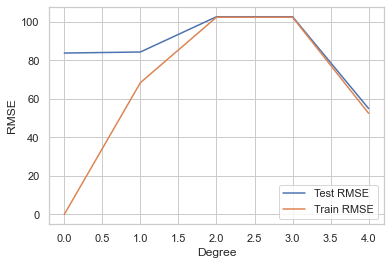

In [32]:
# Plotting the test and train RMSE scores for the models
plt.plot( np.arange(len(RMSE_df_test['Test_RMSE'])) , RMSE_df_test['Test_RMSE'], label='Test RMSE')
plt.plot( np.arange(len(RMSE_df_train['Train_RMSE'])) , RMSE_df_train['Train_RMSE'], label='Train RMSE')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

**X Axis Represents:**

0 = Decision Tree Regression

1 = KNeighbors Regression

2 = Linear Regression

3 = Ridge Regression

4 = XGB Regression

- Test RMSE > Train RMSE = Overfit (Decision Tree, KNeighbors)
- XGB has minimal overfitting.

### Feature Selection

In [33]:
# Chose the top 8 features that could best predict Price_Charged
selector = SelectKBest(k=8)
fit = selector.fit(yellow_x,yellow_y)
X_best = selector.fit_transform(yellow_x,yellow_y)

# Created dataframes showing top columns and their scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(yellow_x.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

# naming the dataframe columns
featureScores.columns = ['Feature','Score']  

# select best features
Top_features= featureScores.nlargest(38,'Score')  

X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, yellow_y, test_size=0.2, random_state=50)

X_train_best = scale.fit_transform(X_train_best)
X_test_best = scale.transform(X_test_best)

In [34]:
Top_features

,Feature,Score
1,KM_Travelled,15.225562
2,Cost_of_Trip,14.341145
6,Population,1.549145
7,Users,1.396691
8,Month,1.052173
3,Customer_ID,1.034850
0,Transaction_ID,1.024417
10,Year,1.017160
9,day,1.016985
4,Age,0.993849


In [35]:
# Train and re-evaulate models - After feature selection

# Ridge
ridge.fit(X_train_best, y_train_best)
ridge_predict_best = ridge.predict(X_test_best)
ridge_RMSE_best = sqrt(metrics.mean_squared_error(y_test_best, ridge_predict_best))

# Decision Tree
dtr.fit(X_train_best, y_train_best)
dtr_predict_best = dtr.predict(X_test_best)
dtr_RMSE_best = sqrt(metrics.mean_squared_error(y_test_best, dtr_predict_best))

# Linear Regression
lm.fit(X_train_best,y_train_best)
lm_predict_best = lm.predict(X_test_best)
lm_RMSE_best = sqrt(metrics.mean_squared_error(y_test_best, lm_predict_best))

# K Neighbours Regressor
knn.fit(X_train_best,y_train_best)
knn_predict_best = knn.predict(X_test_best)
knn_RMSE_best = sqrt(metrics.mean_squared_error(y_test_best, knn_predict_best))

# XGB Booster
xgb.fit(X_train_best, y_train_best)
xgb_predict_best = dtr.predict(X_test_best)
xgb_RMSE_best = sqrt(metrics.mean_squared_error(y_test_best, dtr_predict_best))

In [36]:
# Plot RMSE comarison of before and after feature selection
RMSE_dict_best = {'RMSE_8':
             {
                 "Ridge Regression": ridge_RMSE_best,
                 "Decision Tree Regression": dtr_RMSE_best,
              "Linear Regression": lm_RMSE_best,
              "KNeighbors Regression": knn_RMSE_best,
              "XGB Regression": xgb_RMSE_best 
              }
             }
RMSE_df_best = pd.DataFrame(data=RMSE_dict_best)
RMSE_df_best['RMSE_preselection'] = RMSE_df_test['Test_RMSE']
RMSE_df_best

,RMSE_8,RMSE_preselection
Decision Tree Regression,83.911136,83.861442
KNeighbors Regression,75.409886,84.405434
Linear Regression,102.643175,102.724861
Ridge Regression,102.643005,102.726206
XGB Regression,83.911136,55.010251


- Increase in some model's RMSE.
- Final Model XGB Regression - RMSE Decrease.

### 5. Conclusion

<a class="anchor" id="5"></a>
<a href=#cont>Back to Table of Contents</a>

- Compared numers models.
- Applies Feature Selection and Feature Scaling.
- Successfully able to accurately predict Price_Charged, using a XGB Regression algorithm. (XGB before feature selection)